In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats

import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
session_info = {'date': "06_08_2023",
                'genotype_dir': 'ER4d_sytjGCaMP7f_EPG_jRGECO1a',
                'fly': 'fly2',
                'session': 'baseline-001',
                'full_genotype': '+/-; R60D05-LexA, LexOpjRGECO/ R4d-AD; UASsytjGCaMP7f/R4d-DBD SS00238',
                'ecl date': '7/28-30/2023',
                'notes':'evernote notes'}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.ColumnarRingImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)

In [3]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=1, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()


In [4]:
nap = pp.open_napari()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [6]:
print('done')

done


In [7]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [8]:
y_r4d = pp.calculate_zscored_F('rois_R4d', exp_detrend=True,zscore=False)
y_epg = pp.calculate_zscored_F('rois_EB', exp_detrend=True,zscore=False)

In [9]:
pp.save()

In [10]:
if False:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y_r4d = pp.timeseries['rois_R4d_z']
    y_epg = pp.timeseries['rois_EB_z']
    n_rois=y_r4d.shape[1]
    

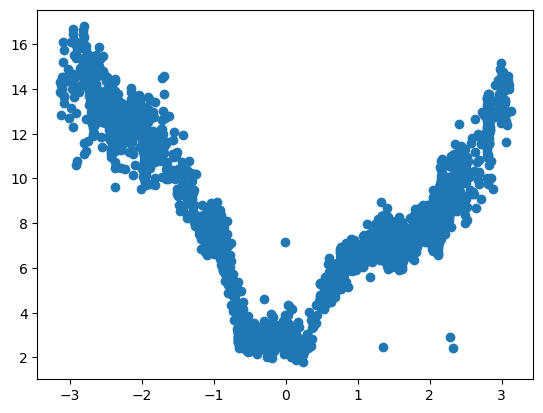

In [11]:
fig, ax = plt.subplots()
heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
heading.shape
pp.timeseries['background'].shape
ax.scatter(-1*pp.voltage_recording_aligned[' Heading'].to_numpy(), pp.timeseries['background'][1,:,:])
mask = np.abs(heading)>1

In [19]:
# y_r4d[1,:,:] -= .7*y_r4d[0,:,:]
y_r4d_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_r4d-1, 2, axis=-1),1,axis=1, mode='wrap')
# y_epg[0,:,:] -= .7*y_epg[1,:,:]
y_epg_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_epg-1, 2, axis=-1),1,axis=1, mode='wrap')

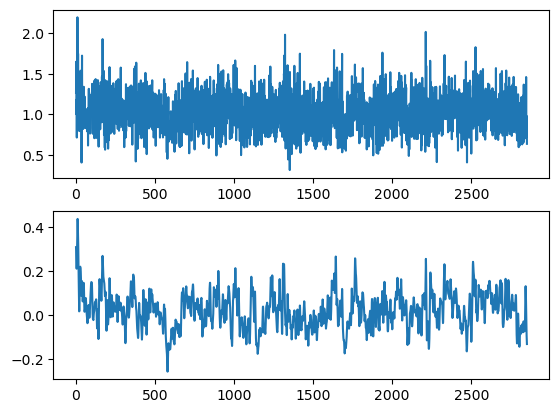

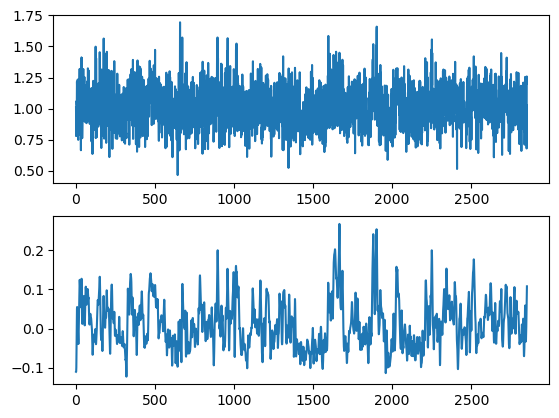

In [20]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_r4d[1,1,:])
ax[1].plot(y_r4d_sm[1,1,:])

fig, ax = plt.subplots(2,1)
ax[0].plot(y_epg[0,1,:])
ax[1].plot(y_epg_sm[0,1,:])

In [21]:
x_f,y_f = st2p.utilities.pol2cart(y_r4d_sm[1,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
# x_f,y_f = st2p.utilities.pol2cart(y_r4d_sm[1,:,:]-y_r4d_sm[1,:,:].mean(axis=0,keepdims=True) ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])

rho_r4d, phi_r4d = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

x_f,y_f = st2p.utilities.pol2cart(y_epg_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
# x_f,y_f = st2p.utilities.pol2cart(y_epg_sm[0,:,:] -y_epg_sm[0,:,:].mean(axis=-1,keepdims=True),np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho_epg, phi_epg = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

_,offset_r4d = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_r4d-heading))
_,offset_epg = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_epg-heading))

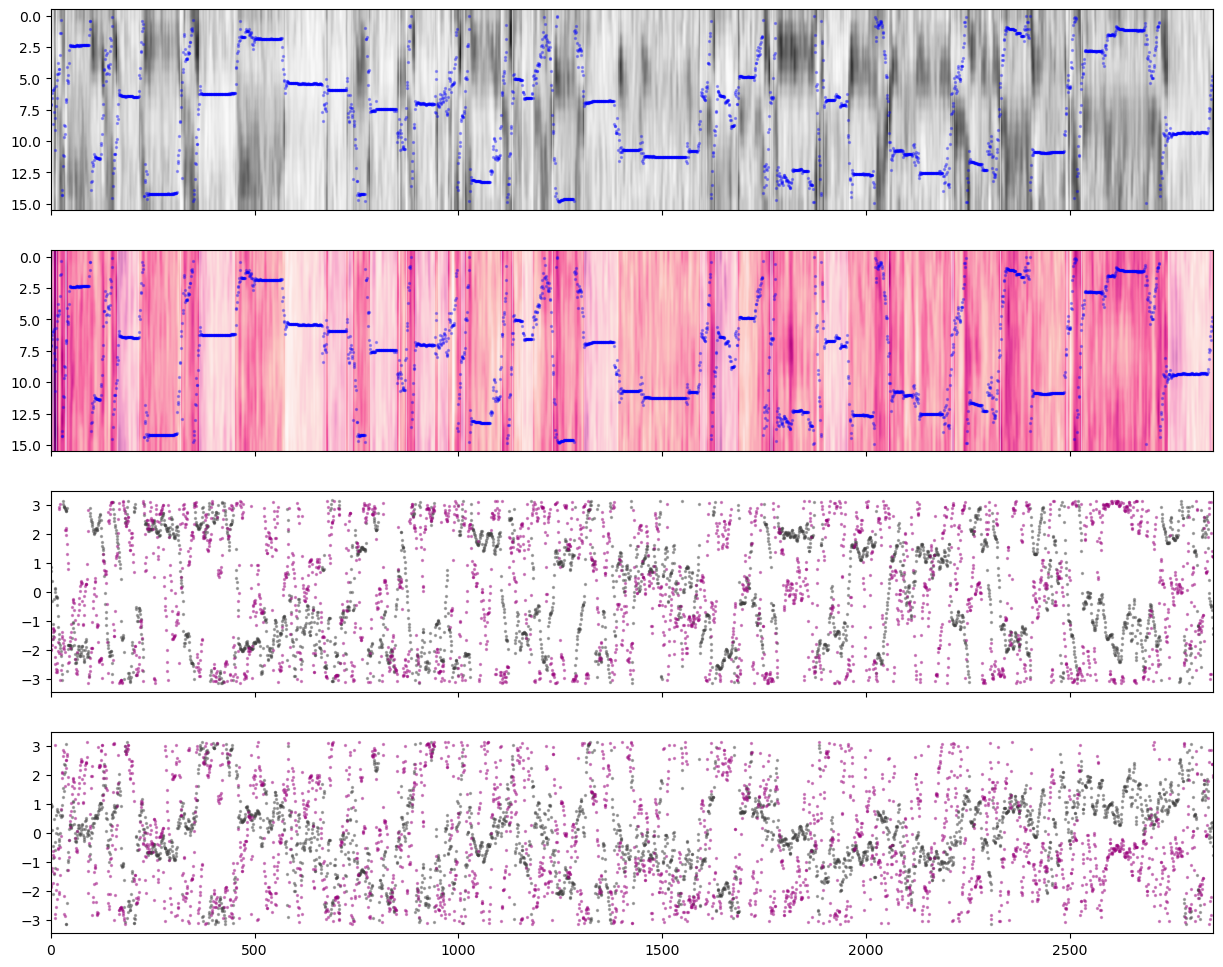

In [22]:
fig, ax= plt.subplots(4,1, figsize=[15,12], sharex=True)
ax[0].imshow(y_epg_sm[0,::-1,:], aspect='auto', cmap= 'Greys')
ax[1].imshow(y_r4d_sm[1,::-1,:], aspect='auto', cmap= 'RdPu') #, vmin=-.4, vmax=.4)


x = np.arange(y_epg.shape[-1])
fill = np.ones_like(y_r4d_sm[1,:,:])
fill[:, mask]=np.nan
ax[0].imshow(fill, aspect='auto', cmap='gray', vmax=1, vmin=0, alpha=.5)
ax[1].imshow(fill, aspect='auto', cmap='gray', vmax=1, vmin=0, alpha=.5)
                   

heading_ = 15*(heading+np.pi)/2/np.pi
ax[0].scatter(x, heading_, alpha=.3, s=2, color='blue')
ax[1].scatter(x, heading_, alpha=.3, s=2, color='blue')


# print(y.shape, heading.shape)
# ax[2].scatter(x,heading)
ax[2].scatter(x, phi_epg, color=plt.cm.Greys(.8), alpha = .4, s=2)
ax[2].scatter(x, phi_r4d, color=plt.cm.RdPu(.8), alpha = .4, s=2)
ax[3].scatter(x, offset_epg, color=plt.cm.Greys(.8), alpha = .4, s=2)
ax[3].scatter(x, offset_r4d, color=plt.cm.RdPu(.8), alpha = .4, s=2)


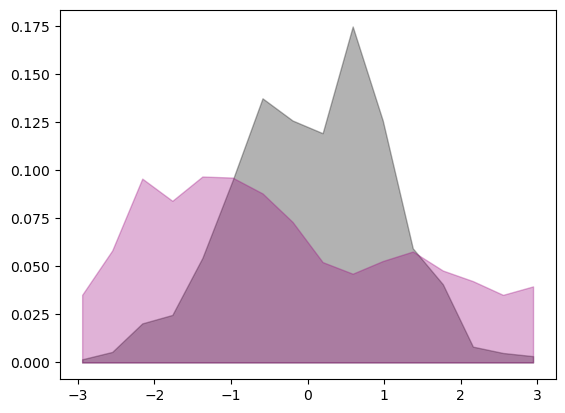

In [23]:
fig, ax= plt.subplots()
bins = np.linspace(-np.pi, np.pi, num=17)
centers = (bins[1:] +bins[:-1])/2



epg_hist,_ = np.histogram(offset_epg[mask], bins)
ax.fill_between(centers, epg_hist/epg_hist.sum(), color='black', alpha=.3)

r4d_hist,_ = np.histogram(offset_r4d[mask], bins)
ax.fill_between(centers, r4d_hist/r4d_hist.sum(), color=plt.cm.RdPu(.8), alpha=.3)

(2, 16, 2853)


(-1.3, 1.3)

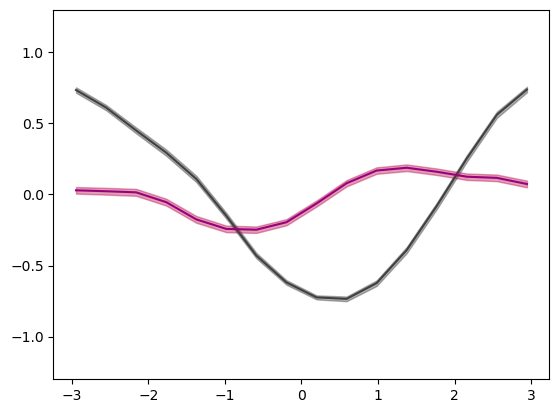

In [24]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
heading_dig = np.digitize(heading, heading_bins)-1

y_h_aligned = np.zeros_like(y_epg_sm)
for ind in range(heading.shape[0]):
    y_h_aligned[0,:,ind] = np.roll(y_epg_sm[0,:,ind], -heading_dig[ind])
    y_h_aligned[1,:,ind] = np.roll(y_r4d_sm[1,:,ind], -heading_dig[ind])
y_h_aligned_z = sp.stats.zscore(y_h_aligned, axis=1)
print(y_h_aligned_z.shape)

fig, ax= plt.subplots()
ha_avg_epg = y_h_aligned_z[0,:,:][:,mask].mean(axis=-1)
ha_sem_epg = sp.stats.sem(y_h_aligned_z[0,:,:][:,mask],axis=-1)
ax.plot(centers, ha_avg_epg, color=plt.cm.Greys(.8))
ax.fill_between(centers, ha_avg_epg - ha_sem_epg, ha_avg_epg + ha_sem_epg, color= plt.cm.Greys(.8), alpha=.4)

ha_avg_r4d = y_h_aligned_z[1,:,:][:,mask].mean(axis=-1)
ha_sem_r4d = sp.stats.sem(y_h_aligned_z[1,:,:][:,mask],axis=-1)
ax.plot(centers, ha_avg_r4d, color=plt.cm.RdPu(.8))
ax.fill_between(centers, ha_avg_r4d - ha_sem_r4d, ha_avg_r4d + ha_sem_r4d, color= plt.cm.PuRd(.8), alpha=.4)


ax.set_ylim([-1.3,1.3])

In [5]:

epg_dig = np.digitize(phi_epg, heading_bins)-1

y_epg_aligned = np.zeros_like(y_epg_sm)
for ind in range(heading.shape[0]):
    y_epg_aligned[0,:,ind] = np.roll(y_epg_sm[0,:,ind], -epg_dig[ind])
    y_epg_aligned[1,:,ind] = np.roll(y_r4d_sm[1,:,ind], -epg_dig[ind])
y_epg_aligned_z = sp.stats.zscore(y_epg_aligned, axis=1)


fig, ax= plt.subplots()
ea_avg_epg = y_epg_aligned_z[0,:,:][:,mask].mean(axis=-1)
ea_sem_epg = sp.stats.sem(y_epg_aligned_z[0,:,:][:,mask],axis=-1)
ax.plot(centers, ea_avg_epg, color=plt.cm.Greys(.8))
ax.fill_between(centers, ea_avg_epg - ea_sem_epg, ea_avg_epg + ea_sem_epg, color= plt.cm.Greys(.8), alpha=.4)

ea_avg_r4d = y_epg_aligned_z[1,:,:][:,mask].mean(axis=-1)
ea_sem_r4d = sp.stats.sem(y_epg_aligned_z[1,:,:][:,mask],axis=-1)
axx = ax.twinx()
axx.plot(centers, ea_avg_r4d, color=plt.cm.RdPu(.8))
axx.fill_between(centers, ea_avg_r4d - ea_sem_r4d, ea_avg_r4d + ea_sem_r4d, color= plt.cm.PuRd(.8), alpha=.4)


# ax.set_ylim([-1.3,1.3])

NameError: name 'phi_epg' is not defined